In [1]:
import seisbench
import seisbench.models as sbm
import obspy
import matplotlib.pyplot as plt
from glob import glob
import os
from obspy.core.inventory.inventory import read_inventory
import pandas as pd
from obspy.geodetics.base import gps2dist_azimuth
from obspy.core.utcdatetime import UTCDateTime
import numpy as np



In [2]:
pn_model = sbm.PhaseNet.from_pretrained("stead")
eqt_model = sbm.EQTransformer.from_pretrained("stead")

/uufs/chpc.utah.edu/common/home/u1072028/software/pkg/miniconda3/envs/seisbench/lib/python3.11/site-packages/seisbench/models/base.py:489: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental

In [30]:
main_dir = "/uufs/chpc.utah.edu/common/home/koper-group4/relu/Spectral_modeling/Utah/"
experiment_name = "BASE"
source_type = "eq"
stat = "I21A"
av_p_vel = 6.0 #km/s
av_s_vel = 3.39 #km/s
cat_file = os.path.join(main_dir, f"Catalogs_BASE_SSIP_073024/{experiment_name}/cat_{experiment_name.lower()}_{source_type.lower()}.csv")
events_dir = os.path.join(main_dir, f"Events_BASE_SSIP_073024/Events_{experiment_name.upper()}_{source_type.upper()}")
print(cat_file)
print(events_dir)


/uufs/chpc.utah.edu/common/home/koper-group4/relu/Spectral_modeling/Utah/Catalogs_BASE_SSIP_073024/BASE/cat_base_eq.csv
/uufs/chpc.utah.edu/common/home/koper-group4/relu/Spectral_modeling/Utah/Events_BASE_SSIP_073024/Events_BASE_EQ


In [4]:
cat = pd.read_csv(cat_file)
cat.head()

,LAT,LON,DEPTH,MAG,MTYPE,EVENT_TYPE,UTC
0,43.733,-107.101,6.1,1.4,Ml,earthquake,2010-06-21T12:01:03.000000Z
1,44.966,-105.957,15.2,0.7,Ml,earthquake,2010-06-29T04:45:22.000000Z
2,44.607,-108.499,18.0,0.9,Ml,earthquake,2010-07-01T23:46:36.000000Z
3,43.874,-106.958,19.2,0.7,Ml,earthquake,2010-07-10T03:20:43.000000Z
4,44.689,-107.786,18.3,0.7,Ml,earthquake,2010-07-15T03:17:46.000000Z


In [32]:
event_row = cat.iloc[0]
event_loc = (event_row["LAT"], event_row["LON"])
event_ot_str = event_row["UTC"]
event_ot_utc = UTCDateTime(event_ot_str)
wf_dir = os.path.join(events_dir, f"{event_ot_str}/Data/waveforms")
xml_dir = os.path.join(events_dir, f"{event_ot_str}/Data/stations")

In [33]:
inv = read_inventory(os.path.join(xml_dir, f"*{stat}*xml"))

In [7]:
stat_loc = (inv[0][0].latitude, inv[0][0].longitude)
print(stat_loc)

(43.812199, -107.292)


In [8]:
sr_dist_km = gps2dist_azimuth(stat_loc[0], stat_loc[1], event_loc[0], event_loc[1])[0]/1000
print(sr_dist_km)

17.717478930925072


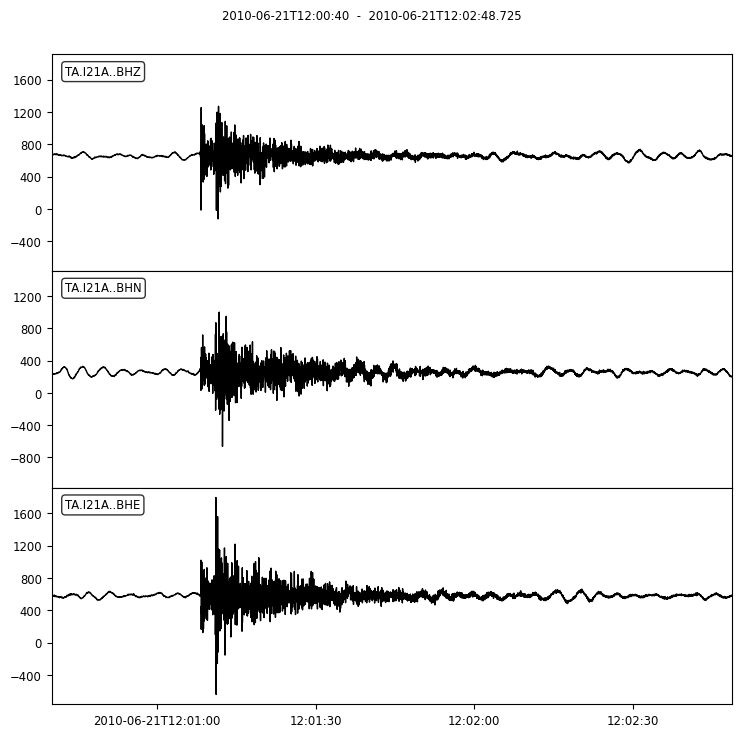

In [9]:
st = obspy.read(os.path.join(wf_dir, f"*{stat}*mseed"))
st.plot();

In [10]:
# T = D/V
p_at = event_ot_utc + sr_dist_km/av_p_vel
s_at = event_ot_utc + sr_dist_km/av_s_vel
print(p_at, s_at)

2010-06-21T12:01:05.952913Z 2010-06-21T12:01:08.226395Z


In [11]:
pn_preds = pn_model.annotate(st)
st_bp_1_45 = st.copy().resample(100).taper(max_percentage=0.05).filter(type="bandpass", freqmin=1, freqmax=45)
eqt_preds = eqt_model.annotate(st_bp_1_45)

In [12]:
pn_picks = pn_model.classify(st)
pn_picks

namespace(creator='PhaseNet',
          picks=PickList with 2 entries:
                
                TA.I21A.	2010-06-21T12:01:08.170000Z	P
                TA.I21A.	2010-06-21T12:01:10.920000Z	S)

In [13]:
eqt_picks = eqt_model.classify(st)
eqt_picks

namespace(creator='EQTransformer',
          picks=PickList with 2 entries:
                
                TA.I21A.	2010-06-21T12:01:08.160000Z	P
                TA.I21A.	2010-06-21T12:01:10.940000Z	S,
          detections=DetectionList with 1 entries:
                     
                     TA.I21A.	2010-06-21T12:01:08.200000Z	2010-06-21T12:01:14.890000Z)

In [14]:
eqt_picks_bp_1_45 = eqt_model.classify(st_bp_1_45)
eqt_picks_bp_1_45

namespace(creator='EQTransformer',
          picks=PickList with 2 entries:
                
                TA.I21A.	2010-06-21T12:01:08.180000Z	P
                TA.I21A.	2010-06-21T12:01:10.970000Z	S,
          detections=DetectionList with 1 entries:
                     
                     TA.I21A.	2010-06-21T12:01:08.210000Z	2010-06-21T12:01:14.940000Z)

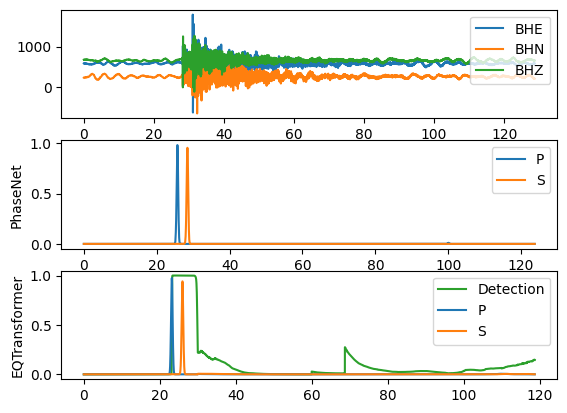

In [15]:
color_dict = {"P": "C0", "S": "C1", "Detection": "C2"}
fig, ax = plt.subplots(3, 1)
for trace in st:
    ax[0].plot(trace.times(), trace.data, label=trace.stats.channel)

for i, preds in enumerate([pn_preds, eqt_preds]):
    for pred_trace in preds:
        model, pred_class = pred_trace.stats.channel.split("_")
        if pred_class == "N":
            # Skip noise traces
            continue
        c = color_dict[pred_class]
        ax[i+1].plot(pred_trace.times(), pred_trace.data, label=pred_class, c=c)
        ax[i+1].set_ylabel(model)

for i in range(3):
    ax[i].legend()

P PhaseNet
P EQTransformer
S PhaseNet
S EQTransformer


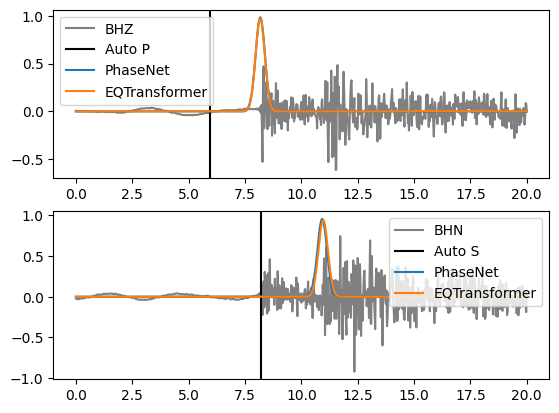

In [16]:
color_dict = {"PhaseNet": "C0", "EQTransformer": "C1"}
fig, ax = plt.subplots(2, 1)

z_trace = st.select(channel="*Z")[0].copy().normalize().detrend(type='demean').trim(st[0].stats.starttime+20, st[0].stats.starttime+40)
n_trace = st.select(channel="*N")[0].copy().normalize().detrend(type='demean').trim(st[0].stats.starttime+20, st[0].stats.starttime+40)

ax[0].plot(z_trace.times(), z_trace.data, label=z_trace.stats.channel, color="gray")
ax[0].axvline(p_at - z_trace.stats.starttime, color="k", label="Auto P")
ax[1].plot(n_trace.times(), n_trace.data, label=n_trace.stats.channel, color="gray")
ax[1].axvline(s_at - z_trace.stats.starttime, color="k", label="Auto S")

for i, phase in enumerate(["P", "S"]):
    for preds in [pn_preds, eqt_preds]:
        pred_trace = preds.select(channel=f"*_{phase}")[0].copy()
        pred_trace.trim(st[0].stats.starttime+20, st[0].stats.starttime+40)
        model, pred_class = pred_trace.stats.channel.split("_")
        print(phase, model)
        c = color_dict[model]
        ax[i].plot(pred_trace.times(), pred_trace.data, label=model, c=c)

for i in range(2):
    ax[i].legend()

# Snuffler Markers File Version 0.2
## Will need to make one of these files for every event

phase: {AT}  {QUALITY} {NET.STAT.LOC.CHAN}  None           None         None         {PHASE}        None False                         
```
phase: 2019-08-26 07:30:48.11105  1 UR.AQ04.00.HHZ  None           None         None         v        None False
phase: 2019-08-26 07:30:48.47951  1 UR.AQ05.00.HHZ  None           None         None         v        None False
phase: 2019-08-26 07:30:48.67588  1 UR.AQ04.00.HHN  None           None         None         S        None False
phase: 2019-08-26 07:30:48.70967  1 LV.L009..HHZ    None           None         None         ^        None False
phase: 2019-08-26 07:30:48.72939  1 LV.L001..HHZ    None           None         None         ^        None False
phase: 2019-08-26 07:30:48.92195  1 UR.AQ06.00.HHZ  None           None         None         ^        None False
phase: 2019-08-26 07:30:49.03929  1 UR.AQ03.00.HHZ  None           None         None         ^        None False
phase: 2019-08-26 07:30:49.31043  1 UR.AQ05.00.HHN  None           None         None         S        None False
phase: 2019-08-26 07:30:49.75813  1 LV.L002..HHZ    None           None         None         ^        None False
```

In [17]:
p1 = pn_picks.picks[0].__dict__
p1

{'trace_id': 'TA.I21A.',
 'start_time': 2010-06-21T12:01:07.850000Z,
 'end_time': 2010-06-21T12:01:08.590000Z,
 'peak_time': 2010-06-21T12:01:08.170000Z,
 'peak_value': 0.98297656,
 'phase': 'P'}

In [66]:
for pick in pn_picks.picks:
    print(pick.__dict__)

{'trace_id': 'TA.I21A.', 'start_time': UTCDateTime(2010, 6, 21, 12, 1, 7, 850000), 'end_time': UTCDateTime(2010, 6, 21, 12, 1, 8, 590000), 'peak_time': UTCDateTime(2010, 6, 21, 12, 1, 8, 170000), 'peak_value': 0.98297656, 'phase': 'P'}
{'trace_id': 'TA.I21A.', 'start_time': UTCDateTime(2010, 6, 21, 12, 1, 10, 580000), 'end_time': UTCDateTime(2010, 6, 21, 12, 1, 11, 330000), 'peak_time': UTCDateTime(2010, 6, 21, 12, 1, 10, 920000), 'peak_value': 0.955755, 'phase': 'S'}


In [61]:
p1["peak_time"]

2010-06-21T12:01:08.170000Z

In [18]:
# There should be a fixed width for each column -> when no location code, there should be two extra spaces after, so each column lines up
f"phase: {p1['peak_time'].strftime('%Y-%m-%d')} {p1['peak_time'].strftime('%H:%M:%S.%f')[:-1]}  1 {p1['trace_id']}{st[0].stats.location}.{st[-1].stats.channel}  None           None         None         {p1['phase']}        None False"

'phase: 2010-06-21 12:01:08.17000  1 TA.I21A..BHZ  None           None         None         P        None False'

In [20]:
df=pd.DataFrame([[f"phase: {p1['peak_time'].strftime('%Y-%m-%d')} {p1['peak_time'].strftime('%H:%M:%S.%f')[:-1]}", 
                   "1", 
                   f"{p1['trace_id']}{st[0].stats.location}.{st[-1].stats.channel}",
                   "None",
                   "None",
                   "None",
                   f"{p1['phase']}",
                   "None",
                   "False"]],
                   columns=["phase.AT", "QUAL", "NET.STAT.LOC.CHAN", "N1", "N2", "N3", "PHASE", "N4", "N5"])
df

,phase.AT,QUAL,NET.STAT.LOC.CHAN,N1,N2,N3,PHASE,N4,N5
0,phase: 2010-06-21 12:01:08.17000,1,TA.I21A..BHZ,None,None,None,P,None,False


In [29]:
# Got this from ChatGPT
# Define column widths
col_widths = [34, 2, 16, 15, 13, 13, 9, 5, 5]

# Function to format each row according to column widths
def format_row(row, col_widths):
    return ''.join(f'{str(row[i]):<{col_widths[i]}}' for i in range(len(row)))

# Open a text file to save the DataFrame
file_path = 'output_with_column_widths.txt'
with open(file_path, 'w') as f:  
    # Write each row with fixed widths
    for _, row in df.iterrows():
        f.write(format_row(row, col_widths) + '\n')

print(f'DataFrame saved to {file_path}')


DataFrame saved to output_with_column_widths.txt


/tmp/ipykernel_3495161/3154570765.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return ''.join(f'{str(row[i]):<{col_widths[i]}}' for i in range(len(row)))


In [67]:
preds

3 Trace(s) in Stream:
TA.I21A..EQTransformer_Detection | 2010-06-21T12:00:45.000000Z - 2010-06-21T12:02:43.740000Z | 100.0 Hz, 11875 samples
TA.I21A..EQTransformer_P         | 2010-06-21T12:00:45.000000Z - 2010-06-21T12:02:43.740000Z | 100.0 Hz, 11875 samples
TA.I21A..EQTransformer_S         | 2010-06-21T12:00:45.000000Z - 2010-06-21T12:02:43.740000Z | 100.0 Hz, 11875 samples